# Gaussian Process Regression with BayeSpace Using Simulated Data

This notebook demonstrates the use of **Gaussian Process Regression (GPR)** with BayeSpace on a series of simulated datasets, increasing in complexity. The goal is to showcase how BayeSpace can model complex functions and spatial patterns using GPR — a flexible, non-parametric method that infers function values and uncertainty without assuming a specific model form.

We will walk through the following examples:

- A simple **line** (1D regression)
- A **curve** (non-linear polynomial)
- A **plane** (2D regression)
- A **non-linear** 2D function

For each example, we generate noisy data, define a kernel structure, and train a Gaussian Process model using BayeSpace. We then visualise the predicted function values and uncertainties over the domain.

This notebook serves as both a tutorial and a showcase of BayeSpace’s GPR functionality across increasingly complex regression problems — from smooth trends to sharp non-linearities.


### Install Libraries

In [1]:
from regression_toolbox.model import Model, add_model, delete_model

from visualisation_toolbox.domain import Domain
from visualisation_toolbox.visualiser import GPVisualiser

from data_processing.sim_data_processor import SimDataProcessor
from data_processing.raw_data_processor import RawDataProcessor

from gaussian_process_toolbox.kernel import Kernel
from gaussian_process_toolbox.gaussian_processor import GP
from gaussian_process_toolbox.transformation import Transformation

import numpy as np
import pandas as pd
import os
import jax

os.chdir('/PhD_project/')
jax.config.update("jax_enable_x64", True)


## Example 1: Gaussian Process Regression on a Line

In this first example, we use BayeSpace to perform **Gaussian Process Regression (GPR)** on simulated data generated from a simple line:  
$$
f(x) = ax + b
$$

The true values used to generate the data are \( a = 1 \), \( b = 1 \), with Gaussian noise of standard deviation 1 added to simulate measurement uncertainty.

Unlike Bayesian Regression, which infers explicit parameter values for \( a \), \( b \), and \( \sigma \), GPR directly models the function \( f(x) \) as a distribution over possible functions, conditioned on the observed data. We use a **Matérn kernel** defined over the 1D input space \( x \), with length scale and smoothness hyperparameters optimised during training.

We visualise the GP’s predictive mean and uncertainty across the domain, demonstrating how GPR captures both the trend and confidence of the inferred function — even for a simple linear case.

This example serves as a baseline for understanding BayeSpace’s GPR capability on well-behaved, 1D data.


In [ ]:
# Add this line if model doesn't exist yet
# add_model('line', 'a*x + b', ['x'], 'y', ['a', 'b'])

# Define the true model for simulation: a line with a = 1, b = 1
sim_model = Model('line').add_fixed_model_param('a', 1).add_fixed_model_param('b', 1)

# Define the input domain for the simulation: 50 points from 0 to 100
sim_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 100).add_domain_param('n_points', 50)
sim_domain.build_domain()

# Generate noisy data using the model and domain, with Gaussian noise
sim_data_processor = SimDataProcessor('linear_example', sim_model, sim_domain, noise_dist='gaussian', noise_level=1)

kernel_config = {('matern', 'x'): [0]} 

# Instantiate the kernel with hyperparameters
kernel_obj = Kernel(kernel_config)
kernel_obj.add_kernel_param('matern', 'x', 'length_scale', 1)           # Initial guess
kernel_obj.add_kernel_param('matern', 'x', 'nu', 2.5)                              # Smoothness
kernel_obj.add_kernel_param('matern', 'x', 'length_scale_bounds', (0.001, 100))     # Bounds for optimisation

# Identity transformation — data remains in log-space
transformation = Transformation('identity')

# Initialise the GP model using the real-world data processor
gp = GP(sim_data_processor, kernel_obj, transformation=transformation)

# Train the GP — fit hyperparameters and compute posterior
gp_model = gp.train()

# Visualise traceplots and autocorrelations for diagnostics
visualiser = GPVisualiser(gp)

# Visualise predicted line with posterior uncertainty
vis_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 100).add_domain_param('n_points', 100)
vis_domain.build_domain()
visualiser.show_predictions(sim_domain, 'predictions', '1D')

FileNotFoundError: [Errno 2] No such file or directory: '/PhD_project/data/processed_sim_data'

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from gaussian_process_toolbox.kernel import Kernel

# Define a spatiotemporal kernel configuration
kernel_config = {
    ('matern', 'xy'): [0, 1],  # Apply Matern kernel to spatial dimensions (latitude, longitude)
    ('rbf', 't'): [2]          # Apply RBF kernel to temporal dimension (time)
}

# Create kernel instance
kernel_obj = Kernel(kernel_config, kernel_concatination='*')

# Set kernel parameters
kernel_obj.add_kernel_param('matern', 'xy', 'length_scale', [1.5, 1.5])
kernel_obj.add_kernel_param('matern', 'xy', 'nu', 1.5)  # Smoothness parameter
kernel_obj.add_kernel_param('rbf', 't', 'length_scale', 2.0)

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()

# Generate synthetic training data: 50 samples in (latitude, longitude, time)
X_train = np.random.rand(50, 3)
y_train = np.sin(X_train[:, 0]) + np.cos(X_train[:, 1]) + 0.1 * X_train[:, 2]

# Fit a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.random.rand(5, 3)
y_pred, y_std = gp.predict(X_test, return_std=True)

print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


Predictions: [1.17985564 1.64034934 1.17305659 1.45529517 1.40458538]
Prediction Standard Deviations: [0.00185778 0.00111878 0.00059362 0.00208792 0.0008923 ]
Optimized Kernel: _KernelTransformer(2.2, 2.12) * _KernelTransformer(3.04)


In [ ]:
# Define a multi-Matern kernel configuration
kernel_config = {
    ('matern', 'spatial'): [0, 1],  # Matern kernel for depth and distance
    ('matern', 'temporal'): [2]     # Separate Matern kernel for time
}

# Create kernel instance
kernel_obj = Kernel(kernel_config, kernel_concatination='*')

# Set kernel parameters
kernel_obj.add_kernel_param('matern', 'spatial', 'length_scale', [3.0, 3.0])
kernel_obj.add_kernel_param('matern', 'spatial', 'nu', 0.5)  # Rougher process
kernel_obj.add_kernel_param('matern', 'temporal', 'length_scale', 5.0)
kernel_obj.add_kernel_param('matern', 'temporal', 'nu', 1.5)  # Smoother process

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()

# Generate synthetic training data: 100 samples (depth, distance, time)
X_train = np.random.rand(100, 3)
y_train = np.sin(X_train[:, 0]) * np.cos(X_train[:, 1]) + 0.2 * X_train[:, 2]

# Fit Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.random.rand(10, 3)
y_pred, y_std = gp.predict(X_test, return_std=True)

print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


Predictions: [0.32265258 0.6288256  0.45706933 0.13910396 0.57288473 0.63817096
 0.88780468 0.66552526 0.48251856 0.45153111]
Prediction Standard Deviations: [0.01075919 0.01581199 0.01703142 0.01478308 0.01334436 0.01450039
 0.02180461 0.01180803 0.01291184 0.01140789]
Optimized Kernel: _KernelTransformer(5.29, 6.12) * _KernelTransformer(2.8)


Constructed Kernel: _KernelTransformer(0.405) + _KernelTransformer(0)
Predictions: [ 0.3001465   0.30639726  0.31114469  0.31506418  0.31904065  0.32412901
  0.33149124  0.34231135  0.35769197  0.37853859  0.40544037  0.43855773
  0.47752872  0.52140559  0.56863238  0.61707141  0.66408309  0.70665865
  0.74159985  0.76573472  0.77615322  0.77044317  0.74690491  0.70472335
  0.64407855  0.56618079  0.47322268  0.36824858  0.25495001  0.1374033
  0.01977201 -0.09399902 -0.2004701  -0.2969469  -0.38165238 -0.45381511
 -0.51366688 -0.56235174 -0.60175719 -0.63428573 -0.66259028 -0.68929972
 -0.71676079 -0.74681956 -0.78066108 -0.81871871 -0.86065765 -0.90542947
 -0.9513882  -0.99645328]
Prediction Standard Deviations: [0.32443083 0.24430753 0.17012683 0.11614847 0.11197529 0.15516286
 0.21225988 0.26780059 0.31626328 0.35512343 0.38308831 0.39962329
 0.40479738 0.39921062 0.38393518 0.36044846 0.330553   0.29628486
 0.25981556 0.22335259 0.18903824 0.15882838 0.13430081 0.116333
 0.1047315

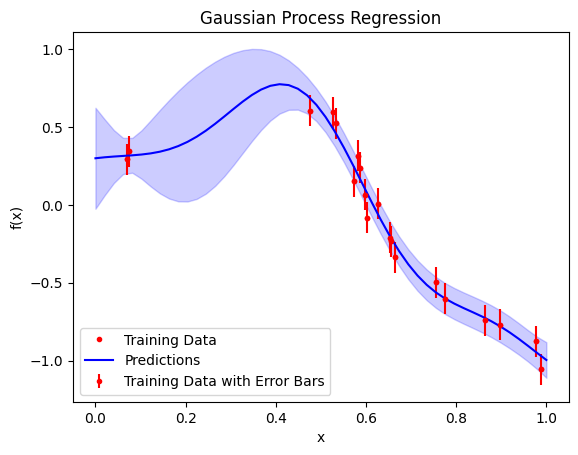

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

# Define kernel configuration for a single RBF kernel applied to 'x' (dimension index 0)
kernel_config = {('rbf', 'x'): [0],
                 ('white', 'x'): [0]}

# Create kernel instance
kernel_obj = Kernel(kernel_config)

# Set kernel parameters
kernel_obj.add_kernel_param('rbf', 'x', 'length_scale', 1.5)

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()
print(f"Constructed Kernel: {gp_kernel}")

# Generate synthetic training data
X_train = np.random.rand(20, 1)  # 20 samples, 1D input (since we're using only 'x')
# Generate synthetic training data with noise
y_train = np.sin(5 * X_train).flatten() + 0.1 * np.random.randn(20)

# Fit a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.linspace(0, 1, 50).reshape(-1, 1)  # 50 test points
y_pred, y_std = gp.predict(X_test, return_std=True)

# Print results
print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


plt.figure()
plt.plot(X_train, y_train, 'r.', label='Training Data')
plt.errorbar(X_train, y_train, yerr=0.1, fmt='r.', label='Training Data with Error Bars')
plt.plot(X_test, y_pred, 'b-', label='Predictions')
plt.fill_between(X_test.flatten(), y_pred - y_std, y_pred + y_std, alpha=0.2, color='blue')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()


In [ ]:
sim_model = Model('line').add_fixed_model_param('a', 1).add_fixed_model_param('b', 1)
sim_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 50)
sim_domain.build_domain()

sim_data_processor = SimDataProcessor('gp_test_1', sim_model, sim_domain, noise_dist='gaussian', noise_level=1)

# Define kernel configuration with Matern kernel applied to 'x' (dimension index 0)
kernel_config = {
    ('matern', 'x'): [0],  # Replace 'rbf' with 'matern'
    ('white', 'x'): [0]     # Keep WhiteKernel for noise handling
}

# Create kernel instance with sensible hyperparameters
kernel_obj = Kernel(kernel_config) \
    .add_kernel_param('matern', 'x', 'length_scale', 1.0) \
    .add_kernel_param('matern', 'x', 'nu', 1.5) \
    .add_kernel_param('white', 'x', 'noise_level', 1) \


# Train the GP model with the new kernel
gp = GP(sim_data_processor, kernel_obj)
gp.train()

# Create a domain for visualization
vis_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 1000)
vis_domain.build_domain()

# Visualize the results
visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title='GP Test 4 (Matern Kernel)', plot_type='1D')


Data loaded from /PhD_project/data/processed_sim_data/gp_test_1
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_1
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_1/instance_2/gaussian_process_model.pkl


In [ ]:
sim_model = Model('parabaloid').add_fixed_model_param('a', 3).add_fixed_model_param('b', 1)
sim_domain = Domain(2, 'rectangular').add_domain_param('min_x', -10).add_domain_param('max_x', 10).add_domain_param('min_y', -10).add_domain_param('max_y', 10).add_domain_param('n_points_x', 40).add_domain_param('n_points_y', 40)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_2', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=1)

kernel_config = {('matern', 'xy'): [0, 1]}

kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'xy', 'length_scale', [1, 1])
kernel_obj.add_kernel_param('matern', 'xy', 'nu', 2.5)
kernel_obj.add_kernel_param('matern', 'xy', 'length_scale_bounds', [(0.1, 10), (0.1,10)])

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(2, 'circular').add_domain_param('radius', 5).add_domain_param('mass', 10000)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='2D')




Data loaded from /PhD_project/data/processed_sim_data/gp_test_2
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_2
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_2/instance_2/gaussian_process_model.pkl


In [ ]:
# add_model('test2D', 'A*sin(x/a)*cos(y/b) + B*exp(-(x^2 + y^2)/c^2)', ['x', 'y'], 'C', ['A', 'B', 'a', 'b', 'c'])

# add_model('test2D_4', 'exp(sqrt(x^2 + y^2)/c^2)', ['x', 'y'], 'C', ['c'])

sim_model = Model('test2D_4').add_fixed_model_param('c', 1)
sim_domain = Domain(2, 'rectangular').add_domain_param('min_x', -10).add_domain_param('max_x', 10).add_domain_param('min_y', -10).add_domain_param('max_y', 10).add_domain_param('n_points_x', 60).add_domain_param('n_points_y', 60)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_3', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=0)

kernel_config = {('matern', 'xy'): [0, 1]}

kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'xy', 'length_scale', [1, 1])
kernel_obj.add_kernel_param('matern', 'xy', 'nu', 1.5)
kernel_obj.add_kernel_param('matern', 'xy', 'length_scale_bounds', [(0.01, 100), (0.01,100)])

gp = GP(sim_data_processor, kernel_obj, transformation=Transformation('log'))
gp_model = gp.train()

vis_domain = Domain(2, 'circular').add_domain_param('radius', 5).add_domain_param('mass', 10000)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='2D', scale='log')




Data loaded from /PhD_project/data/processed_sim_data/gp_test_3
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_3
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_3/instance_6/gaussian_process_model.pkl


In [ ]:
# add_model('ellipsoid3D', 'A * exp(-(x^2/a^2 + y^2/b^2 + z^2/c^2))', 
#           ['x', 'y', 'z'], 'D', ['A', 'a', 'b', 'c'])


sim_model = Model('ellipsoid3D').add_fixed_model_param('A', 1).add_fixed_model_param('a', 3).add_fixed_model_param('b', 4).add_fixed_model_param('c', 5)
sim_domain = Domain(3, 'cuboidal').add_domain_param('min_x', -10).add_domain_param('max_x', 10).add_domain_param('min_y', -10).add_domain_param('max_y', 10).add_domain_param('n_points_x', 10).add_domain_param('n_points_y', 10).add_domain_param('min_z', -10).add_domain_param('max_z', 10).add_domain_param('n_points_z', 10)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_6', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=0.1)

kernel_config = {('matern', 'xyz'): [0, 1, 2]}

kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'xyz', 'length_scale', [1, 1, 1])
kernel_obj.add_kernel_param('matern', 'xyz', 'nu', 2.5)
kernel_obj.add_kernel_param('matern', 'xyz', 'length_scale_bounds', (0.01, 100))

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(3, 'spherical').add_domain_param('radius', 5).add_domain_param('mass', 10000)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='3D')
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='3D_recursive')

Data loaded from /PhD_project/data/processed_sim_data/gp_test_6
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_6
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_6/instance_2/gaussian_process_model.pkl


In [ ]:
# add_model('wave1D', 'A * sin(2 * pi * (x / a - t / b))', 
#           ['x', 't'], 'D', ['A', 'a', 'b'])
 
sim_model = Model('wave1D').add_fixed_model_param('A', 1).add_fixed_model_param('a', 3).add_fixed_model_param('b', 4)
sim_domain = Domain(1, 'linear', time_array = np.linspace(0.5,5,10), dim_names=['x', 't']).add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 50)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_7', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=0.1)

kernel_config = {('matern', 'x'): [0], ('rbf', 't'): [1]}
kernel_obj = Kernel(kernel_config).add_kernel_param('matern', 'x', 'length_scale', 1.5)
kernel_obj.add_kernel_param('rbf', 't', 'length_scale', 2.0)

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(1, 'linear', time_array = np.linspace(0.5,5,10), dim_names=['x', 't']).add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 100)
vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title = 'GP Test 5', plot_type='1D_time')

Data loaded from /PhD_project/data/processed_sim_data/gp_test_7
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_7
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_7/instance_2/gaussian_process_model.pkl


In [ ]:
# add_model('wave2D', 'A * sin(2 * pi * (x / a + y / b - t / c))', 
#           ['x', 'y', 't'], 'D', ['A', 'a', 'b', 'c'])

sim_model = Model('wave2D') \
    .add_fixed_model_param('A', 1) \
    .add_fixed_model_param('a', 3) \
    .add_fixed_model_param('b', 4) \
    .add_fixed_model_param('c', 5)

sim_domain = Domain(2, 'rectangular', time_array=np.linspace(0, 5, 10), dim_names=['x', 'y', 't']) \
    .add_domain_param('min_x', 0).add_domain_param('max_x', 10).add_domain_param('n_points_x', 15) \
    .add_domain_param('min_y', 0).add_domain_param('max_y', 10).add_domain_param('n_points_y', 15)

sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_8', sim_model, sim_domain, noise_dist='gaussian', noise_level=0.1)

kernel_config = {('matern', 'xy'): [0, 1], ('rbf', 't'): [2]}
kernel_obj = Kernel(kernel_config) \
    .add_kernel_param('matern', 'xy', 'length_scale', [1.5, 1.5]) \
    .add_kernel_param('matern', 'xy', 'nu', 1.5) \
    .add_kernel_param('matern', 'xy', 'length_scale_bounds', (0.1, 10)) \
    .add_kernel_param('rbf', 't', 'length_scale', 2.0) \
    .add_kernel_param('rbf', 't', 'length_scale_bounds', (0.1, 10))

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(2, 'rectangular', time_array=np.linspace(0, 5, 10), dim_names=['x', 'y', 't']) \
    .add_domain_param('min_x', 0).add_domain_param('max_x', 10).add_domain_param('n_points_x', 30) \
    .add_domain_param('min_y', 0).add_domain_param('max_y', 10).add_domain_param('n_points_y', 30)

vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title='GP Test 2D Time', plot_type='2D_time')


Data loaded from /PhD_project/data/processed_sim_data/gp_test_8
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_8
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_8/instance_2/gaussian_process_model.pkl


In [ ]:
# add_model('wave3D_2', 'A * exp(-((x/a)^2 + (y/b)^2 + (z/c)^2)) * exp(2 * pi * (t / d))', 
#           ['x', 'y', 'z', 't'], 'D', ['A', 'a', 'b', 'c', 'd'])

sim_model = Model('wave3D_2') \
    .add_fixed_model_param('A', 1) \
    .add_fixed_model_param('a', 3) \
    .add_fixed_model_param('b', 4) \
    .add_fixed_model_param('c', 5) \
    .add_fixed_model_param('d', 6)

sim_domain = Domain(3, 'cuboidal', time_array=np.linspace(0, 5, 5), dim_names=['x', 'y', 'z', 't']) \
    .add_domain_param('min_x', -5).add_domain_param('max_x', 5).add_domain_param('n_points_x', 5) \
    .add_domain_param('min_y', -5).add_domain_param('max_y', 5).add_domain_param('n_points_y', 5) \
    .add_domain_param('min_z', -5).add_domain_param('max_z', 5).add_domain_param('n_points_z', 5)

sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_9', sim_model, sim_domain, noise_dist='gaussian', noise_level=0)

kernel_config = {('matern', 'xyz'): [0, 1, 2], ('rbf', 't'): [3]}
kernel_obj = Kernel(kernel_config) \
    .add_kernel_param('matern', 'xyz', 'length_scale', [1.5, 1.5, 1.5]) \
    .add_kernel_param('matern', 'xyz', 'nu', 1.5) \
    .add_kernel_param('matern', 'xyz', 'length_scale_bounds', (0.1, 10)) \
    .add_kernel_param('rbf', 't', 'length_scale', 2.0) \
    .add_kernel_param('rbf', 't', 'length_scale_bounds', (0.1, 10))

uncertainty_params = {
    'precision_error': 0.1,
}
gp = GP(sim_data_processor, 
        kernel_obj, 
        transformation=Transformation('log1p'), 
        uncertainty_method='precision', 
        uncertainty_params=uncertainty_params)
gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(3, 'cuboidal', time_array=np.linspace(0, 5, 10), dim_names=['x', 'y', 'z', 't']) \
    .add_domain_param('min_x', -5).add_domain_param('max_x', 5).add_domain_param('n_points_x', 30) \
    .add_domain_param('min_y', -5).add_domain_param('max_y', 5).add_domain_param('n_points_y', 30) \
    .add_domain_param('min_z', -5).add_domain_param('max_z', 5).add_domain_param('n_points_z', 30)

vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title='GP Test 3D Time', plot_type='3D_time')


Data loaded from /PhD_project/data/processed_sim_data/gp_test_9
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_9
Data loaded from /PhD_project/data/processed_sim_data/gp_test_9
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_9
Loading existing GP model from /PhD_project/results/gaussian_process_results/gp_test_9/instance_9/gaussian_process_model.pkl


In [ ]:
processor_params = {
    'identifier': 'aves',
    'tax_group': 'class',
    'num_x_cells': 10,
    'num_y_cells': 10,
    'timestep': 'year',
    'output_header': 'counts'
}

raw_data_processor = RawDataProcessor('xylo_test_project', 'xylo_test_2', 'XYLO_processor', processor_params)
processed_data, _ = raw_data_processor.process_data()
x_min = processed_data['x'].min()
x_max = processed_data['x'].max()
y_min = processed_data['y'].min()
y_max = processed_data['y'].max()
t_min = processed_data['t'].min()
t_max = processed_data['t'].max()

kernel_config = {('matern', 'xy'): [0, 1], ('rbf', 't'): [2]}
kernel_obj = Kernel(kernel_config) \
    .add_kernel_param('matern', 'xy', 'length_scale', [1.5, 1.5]) \
    .add_kernel_param('matern', 'xy', 'nu', 1.5) \
    .add_kernel_param('matern', 'xy', 'length_scale_bounds', (0.1, 10)) \
    .add_kernel_param('rbf', 't', 'length_scale', 2.0) \
    .add_kernel_param('rbf', 't', 'length_scale_bounds', (0.1, 10))

uncertainty_params = {
    'precision_error': 0.1,
    'zero_count_error': 1
}
gp = GP(raw_data_processor, 
        kernel_obj, 
        transformation=Transformation('log1p'), 
        uncertainty_method='XYLO_uncertainty', 
        uncertainty_params=uncertainty_params)

gp_model = gp.train()

vis_domain = Domain(2, 'rectangular', time_array=np.arange(t_min, t_max, 1), dim_names=['x', 'y', 't']) \
    .add_domain_param('min_x', x_min).add_domain_param('max_x', x_max).add_domain_param('n_points_x', 30) \
    .add_domain_param('min_y', y_min).add_domain_param('max_y', y_max).add_domain_param('n_points_y', 30)

vis_domain.build_domain()

visualiser = GPVisualiser(gp)
visualiser.show_predictions(vis_domain, 'test', title='GP Test 2D Time', plot_type='2D_time')

Data loaded from data/processed_raw_data/xylo_test_2
Data loaded from data/processed_raw_data/xylo_test_2
Loading existing GP model from /PhD_project/results/gaussian_process_results/xylo_test_2/instance_2/gaussian_process_model.pkl


In [ ]:
# add_model('sin', 'A * sin(B * x + C) + D', ['x'], 'y', ['A', 'B', 'C', 'D'])

sim_model = Model('sin').add_fixed_model_param('A', 1).add_fixed_model_param('B', 1).add_fixed_model_param('C', 0).add_fixed_model_param('D', 0)
sim_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 50)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_10', sim_model, sim_domain, noise_dist='gaussian', noise_percentage=0.5)
sim_data_processor.process_data()

Data loaded from /PhD_project/data/processed_sim_data/gp_test_10
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_10


[    Unnamed: 0          x         y    y_true
 12          12   2.448980  0.729252  0.638550
 4            4   0.816327  0.835853  0.728635
 37          37   7.551020  0.798296  0.954457
 8            8   1.632653  0.858149  0.998087
 3            3   0.612245  0.531819  0.574706
 6            6   1.224490  0.771494  0.940633
 41          41   8.367347  0.948427  0.871097
 46          46   9.387755  0.036783  0.037014
 47          47   9.591837 -0.177167 -0.166283
 15          15   3.061224  0.080543  0.080282
 9            9   1.836735  1.070700  0.964846
 16          16   3.265306 -0.121329 -0.123398
 24          24   4.897959 -1.289284 -0.982831
 34          34   6.938776  0.658580  0.609627
 31          31   6.326531  0.043978  0.043332
 0            0   0.000000  0.000000  0.000000
 44          44   8.979592  0.450965  0.430626
 27          27   5.510204 -0.714968 -0.698272
 33          33   6.734694  0.431780  0.436323
 5            5   1.020408  0.459608  0.852322
 29          

In [ ]:
# add_model('plane', 'a*x + b*y +c', ['x', 'y'], 'C', ['a', 'b', 'c'])

sim_model = Model('plane').add_fixed_model_param('a', 1).add_fixed_model_param('b', 1).add_fixed_model_param('c', 1)
sim_domain = Domain(2, 'circular').add_domain_param('radius', 5).add_domain_param('mass', 5000)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_11', sim_model, sim_domain, noise_dist='gaussian', noise_level = 1)
sim_data_processor.process_data()

Data loaded from /PhD_project/data/processed_sim_data/gp_test_11
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_11


[      Unnamed: 0         x         y         C    C_true
 3290        3290  0.514582  0.969710  2.913460  2.484293
 2333        2333 -0.738732 -3.480437 -2.121768 -3.219169
 4553        4553  2.394553 -4.131678 -0.282135 -0.737125
 3168        3168  0.389251 -2.395035 -1.621613 -1.005785
 2760        2760 -0.174741  3.249054  4.076328  4.074314
 ...          ...       ...       ...       ...       ...
 3772        3772  1.203905  4.117376  6.912167  6.321281
 5191        5191  3.459870  0.427009  5.277960  4.886880
 5226        5226  3.585202 -2.937736  1.945506  1.647465
 5390        5390  3.835865  1.295331  4.455971  6.131196
 860          860 -2.932032  1.946572  1.054759  0.014540
 
 [4613 rows x 5 columns],
       Unnamed: 0         x         y         C    C_true
 3262        3262  0.577248 -2.069415  0.260225 -0.492167
 4577        4577  2.394553 -1.526714 -0.356621  1.867839
 2213        2213 -0.926729  3.249054  3.164142  3.322325
 3226        3226  0.451916  3.900295  6.065

In [ ]:
# add_model('3D_plane', 'a*x + b*y +c*z + d', ['x', 'y', 'z'], 'C', ['a', 'b', 'c', 'd'])

sim_model = Model('3D_plane').add_fixed_model_param('a', 1).add_fixed_model_param('b', 1).add_fixed_model_param('c', 1).add_fixed_model_param('d', 1)
sim_domain = Domain(3, 'cylindrical').add_domain_param('radius', 5).add_domain_param('mass', 5000).add_domain_param('height', 10)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_12', sim_model, sim_domain, noise_dist='gaussian', noise_percentage=  0.2)
sim_data_processor.process_data()

Data loaded from /PhD_project/data/processed_sim_data/gp_test_12
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_12


[      Unnamed: 0         x         y         z         C     C_true
 1600        1600 -3.651099  1.541821 -2.663636 -4.275061  -3.772914
 90            90  0.665383 -0.093635 -5.000000 -3.403425  -3.428252
 5997        5997  3.632964 -2.663636  4.812731  6.854899   6.782060
 5642        5642 -2.571979  3.410912  3.878185  5.065299   5.717118
 3946        3946  1.744503  3.410912  1.074548  7.514325   7.229963
 ...          ...       ...       ...       ...       ...        ...
 3772        3772  1.204943 -1.261817  1.074548  1.976058   2.017674
 5191        5191  4.442305  1.074548  3.410912  7.543197   9.927764
 5226        5226  4.442305  2.009093  3.410912  4.211169  10.862310
 5390        5390 -2.302199 -3.598181  3.878185 -0.993752  -1.022195
 860          860 -2.032419 -3.130908 -3.598181 -9.237878  -7.761508
 
 [5204 rows x 6 columns],
       Unnamed: 0         x         y         z         C     C_true
 5638        5638  3.093404  2.943639  3.878185  9.687199  10.915228
 3153 

In [ ]:
delete_model('exp_test')
add_model('exp_test', '(A * sin(x/a + omega * t) * cos(y/b + nu * t) + B * exp(-(x**2 + y**2)/c**2)) * exp(-alpha * t)', ['x', 'y', 't'], 'C', ['A', 'B', 'a', 'b', 'c', 'omega', 'nu', 'alpha'])

sim_model = Model('exp_test').add_fixed_model_param('A', 1).add_fixed_model_param('B', 1).add_fixed_model_param('a', 1).add_fixed_model_param('b', 1).add_fixed_model_param('c', 1).add_fixed_model_param('alpha', 1).add_fixed_model_param('omega', 1).add_fixed_model_param('nu', 1)
sim_domain = Domain(2, 'circular', dim_names=['x', 'y', 't'], time_array=[0, 1, 2]).add_domain_param('radius', 5).add_domain_param('mass', 2000)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_13', sim_model, sim_domain, noise_dist='gaussian', noise_level = 0.5)
sim_data_processor.process_data()

Data generated and saved to /PhD_project/data/processed_sim_data/gp_test_13
Plot saved at: /PhD_project/data/processed_sim_data/gp_test_13


[             x         y  t         C    C_true
 3196 -0.838506 -4.485149  1 -0.155656 -0.055696
 3071 -1.333922  3.409238  1  0.055979  0.035995
 6662  3.422071 -0.537955  2  0.075841 -0.011142
 5582 -0.640340 -0.023104  2 -0.248044  0.037490
 969  -0.541257 -1.224424  0  0.082949 -0.008311
 ...        ...       ... ..       ...       ...
 3772  1.242240 -4.656766  1 -0.200068 -0.250639
 5191 -2.027505  0.148513  2  0.117006  0.004203
 5226 -1.829338 -3.112212  2 -0.099339  0.010175
 5390 -1.135756 -3.627063  2 -0.344071 -0.005789
 860  -1.036673 -0.366338  0 -0.128389 -0.505075
 
 [5527 rows x 5 columns],
              x         y  t         C    C_true
 5665 -0.442174  4.267324  2  0.173385  0.135307
 994  -0.541257  3.066004  0  0.328946  0.513804
 6061  1.044074  2.722770  2 -0.454100  0.000164
 5711 -0.244007  2.207918  2  0.082971 -0.063321
 4094  2.233072  3.752472  1 -0.040791 -0.001347
 ...        ...       ... ..       ...       ...
 3918  1.539490  1.178216  1  0.236763 -0